# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

### Overview of the AZDIAS Dataset

In [3]:
display(azdias.describe())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

### Identify Missing or Unknown Data Values and Convert Them to NaNs.

In [5]:
# Identify missing or unknown data values and convert them to NaNs.

for index, row in feat_info.iterrows():
    aa = "{}".format(row['attribute'])
   
    if row['missing_or_unknown'] != '[]':
        bb = row['missing_or_unknown'].replace(']','').replace('[','').split(',')
        bb = [int(x) if x < 'X' else x for x in bb]
        azdias[aa].replace(bb, np.NAN, inplace=True)


In [6]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

## Calculating the Percentages of Missing data for each Column

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azNA = azdias.isnull().sum(axis = 0)
azNA = 100*azNA/(azNA.max())

### Distribution Missing Values on the Dataset by Columns.

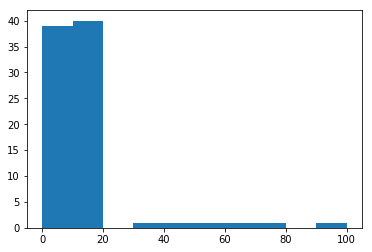

In [8]:
_ = plt.hist(azNA)

/home/dio/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


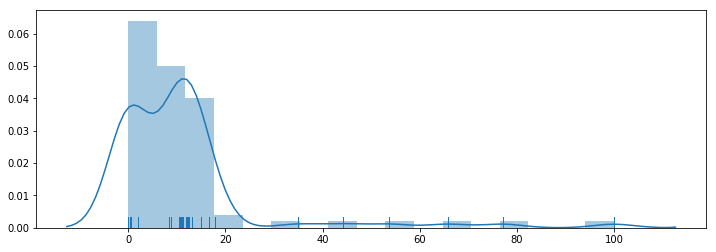

In [9]:
f, ax = plt.subplots(figsize=(12, 4))
_ = sb.distplot(azNA, rug=True)

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azNA_sorted = azNA.sort_values(ascending=False)
print("Top 20 columns, for amount of missing data ")
azNA_sorted.head(20)


Top 20 columns, for amount of missing data 


TITEL_KZ          100.000000
AGER_TYP           77.142401
KK_KUNDENTYP       65.756118
KBA05_BAUMAX       53.598572
GEBURTSJAHR        44.127231
ALTER_HH           34.898280
REGIOTYP           17.778758
KKK                17.778758
W_KEIT_KIND_HH     16.645427
KBA05_ANTG4        14.996046
KBA05_GBZ          14.996046
MOBI_REGIO         14.996046
KBA05_ANTG1        14.996046
KBA05_ANTG2        14.996046
KBA05_ANTG3        14.996046
PLZ8_GBZ           13.105400
PLZ8_HHZ           13.105400
PLZ8_BAUMAX        13.105400
PLZ8_ANTG4         13.105400
PLZ8_ANTG1         13.105400
dtype: float64

### Removing the Top 6 Variables with Largest Percentages of Missing Data

In [11]:
drop_variables = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
azdias=azdias.drop(drop_variables, axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column

From the dataset, the listed below columns have been removed. The decision was based on the fact they are the outliers of the missing data distribution.
The definition of out lier was  based on the percentage of missing data, the remaining variables are concentrates in the 0 to 20% range interval.

         Feature  (% Missing data)

         TITEL_KZ      100.000000%

         AGER_TYP      77.142401%

         KK_KUNDENTYP  65.756118%

         KBA05_BAUMAX  53.598572%

         GEBURTSJAHR   44.127231%

         ALTER_HH      34.898280%
         

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

###  For Each Row is computed the Percentage Amount of Missing Data.

In [12]:
# How much data is missing in each row of the dataset?
azNA_row = azdias.isnull().sum(axis = 1)
azNA_row=100*azNA_row/79


In [13]:
azNA_Row_sorted = azNA_row.sort_values(ascending=False)
print("Top 5 rows with missing data")
azNA_Row_sorted.head(5)

Top 5 rows with missing data


643174    62.025316
732775    62.025316
472919    60.759494
183108    59.493671
139316    59.493671
dtype: float64

In [14]:
azNA_row.describe()

count    891221.000000
mean          7.151764
std          16.752768
min           0.000000
25%           0.000000
50%           0.000000
75%           3.797468
max          62.025316
dtype: float64

/home/dio/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


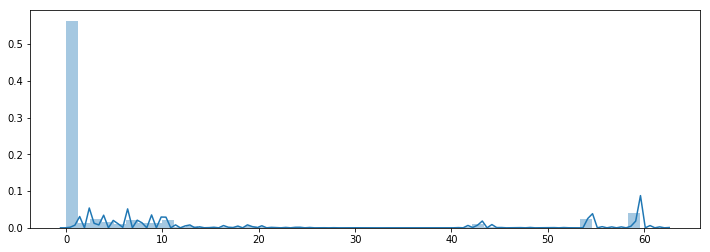

In [15]:
f, ax = plt.subplots(figsize=(12, 4))
_ = sb.distplot(azNA_row, rug=False)

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Added to the AZDIAS Data-frame the column with the percentage of missing data for the row
azdias=azdias.join(pd.DataFrame(azNA_row, columns=["Missing"]))
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Missing
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.430380
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.000000
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.000000
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,8.860759
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.000000


### Function to Split the Data frame in Two, with or without missing data on each row.

Most of the rows have no missing data (70%), since most of the model work better without missing data.

And since the size of the dataset is big enough to tolerate a reduction of 30 % of row.

It was decided a zero tolerance for the missing data, and a threshold 0 was set.

In [17]:
def subsetter(data=azdias,  threshold=0/79):
    print("Original dataset shape: {}".format(data.shape))
    low_missing = data[data["Missing"] <= threshold]
    high_missing = data[data["Missing"] > threshold]
    print("Low Missing  dataset shape: {}".format(low_missing.shape))
    print("High Missing  dataset shape: {}".format(high_missing.shape))
    return low_missing, high_missing
low, high=subsetter()  

Original dataset shape: (891221, 80)
Low Missing  dataset shape: (623209, 80)
High Missing  dataset shape: (268012, 80)


In [ ]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

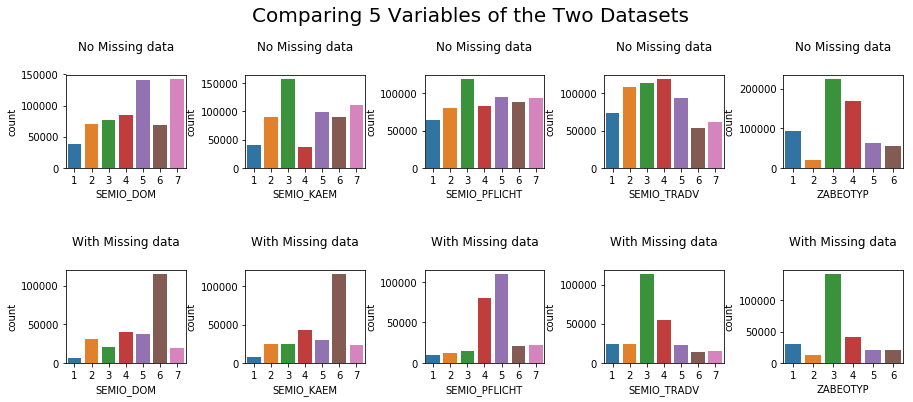

In [18]:
fig, ax = plt.subplots(figsize=(15,5), ncols=5, nrows=2)

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

# The amount of space above titles
y_title_margin = 1.2

plt.suptitle("Comparing 5 Variables of the Two Datasets", y = 1.09, fontsize=20)

for i in range(0,5):
    ax[0][i].set_title("No Missing data", y = y_title_margin)
    ax[1][i].set_title("With Missing data", y = y_title_margin)

sns.countplot(x="SEMIO_DOM", data=low , ax=ax[0][0])
sns.countplot(x="SEMIO_KAEM",   data=low, ax=ax[0][1])
sns.countplot(x="SEMIO_PFLICHT",  data=low, ax=ax[0][2])
sns.countplot(x="SEMIO_TRADV",  data=low, ax=ax[0][3])
sns.countplot(x="ZABEOTYP",  data=low, ax=ax[0][4])

sns.countplot(x="SEMIO_DOM", data=high, ax=ax[1][0])
sns.countplot(x="SEMIO_KAEM", data=high, ax=ax[1][1])
sns.countplot(x="SEMIO_PFLICHT", data=high, ax=ax[1][2])
sns.countplot(x="SEMIO_TRADV",  data=high, ax=ax[1][3])
sns.countplot(x="ZABEOTYP",  data=high, ax=ax[1][4])


### For the five Variables Computed the Chi2 Contingency Test.

In [19]:
from scipy import stats

for f in ["SEMIO_DOM", "SEMIO_KAEM", "SEMIO_PFLICHT", "SEMIO_TRADV", "ZABEOTYP"]:
    lowcount=low[f].value_counts()
    highcount=high[f].value_counts()
    group=np.array([lowcount, highcount])
    chi, p, degre, table=stats.chi2_contingency(group)
    print("p value for {} -> {}".format(f, p))

p value for SEMIO_DOM -> 0.0
p value for SEMIO_KAEM -> 0.0
p value for SEMIO_PFLICHT -> 0.0
p value for SEMIO_TRADV -> 0.0
p value for ZABEOTYP -> 0.0


In [20]:
#Filtering out all the rows with missing data.

azdias,_ = subsetter(data=azdias,  threshold=0)

Original dataset shape: (891221, 80)
Low Missing  dataset shape: (623209, 80)
High Missing  dataset shape: (268012, 80)


In [21]:
# the temporay variable "missing" is droped
azdias = azdias.drop(["Missing"], axis=1)

In [22]:
azdias.shape

(623209, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Unfortunately the variables of the two datasets have nearly always different distribution.
On the plot of the 5 variable can be visualize the different distribution, in additions the computation of the
chi2 contingency test confirm that the distribution are statistically different.


Any how the original dataframe have been split in two dataframe as show below.  
Original dataset shape: (891221, 80)

Low Missing  dataset shape: (623209, 79)

High Missing  dataset shape: (268012, 79)

It was decide to reject any row with missing data.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?

display(feat_info["type"].value_counts())

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# .... List of Categorical Variables ....
ordinal= list(feat_info[feat_info["type"] == "categorical"]["attribute"])
ordinal


['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [25]:
# List of Possible Values for  Each Categorical Variable
for item in ordinal:
    if item not in ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']:
        temp = set(azdias[item].unique())
        print('Variable "{}", Number possible value: {},  list of values {}'.format(item, len(temp), temp) )
    

Variable "ANREDE_KZ", Number possible value: 2,  list of values {1, 2}
Variable "CJT_GESAMTTYP", Number possible value: 6,  list of values {1.0, 2.0, 3.0, 4.0, 5.0, 6.0}
Variable "FINANZTYP", Number possible value: 6,  list of values {1, 2, 3, 4, 5, 6}
Variable "GFK_URLAUBERTYP", Number possible value: 12,  list of values {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0}
Variable "GREEN_AVANTGARDE", Number possible value: 2,  list of values {0, 1}
Variable "LP_FAMILIE_FEIN", Number possible value: 11,  list of values {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0}
Variable "LP_FAMILIE_GROB", Number possible value: 5,  list of values {1.0, 2.0, 3.0, 4.0, 5.0}
Variable "LP_STATUS_FEIN", Number possible value: 10,  list of values {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
Variable "LP_STATUS_GROB", Number possible value: 5,  list of values {1.0, 2.0, 3.0, 4.0, 5.0}
Variable "NATIONALITAET_KZ", Number possible value: 3,  list of values {1.0, 2.0, 3.0}
Varia

## Summary for the Categorical Features

### Binary (ok as they are)
    
    "ANREDE_KZ" 
    "GREEN_AVANTGARDE"
    "VERS_TYP"
    
### Binary --> to convert
    "OST_WEST_KZ" 
    
### Categorical Multivalued 
    "CJT_GESAMTTYP"
    "FINANZTYP"
    "GFK_URLAUBERTYP"
    "LP_FAMILIE_FEIN"
    "LP_FAMILIE_GROB"
    "LP_STATUS_FEIN"
    "LP_STATUS_GROB"
    "NATIONALITAET_KZ"
    "SHOPPER_TYP"
    "SOHO_KZ"
    "ZABEOTYP"
    "GEBAEUDETYP"
    "CAMEO_DEUG_2015"
    "CAMEO_DEU_2015"
    
    

In [26]:
# Binary --> to convert
dictionary = {'W':0, 'O':1}
azdias["OST_WEST_KZ"] = azdias["OST_WEST_KZ"].map(dictionary)

In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.
categoricals = [ "CJT_GESAMTTYP", "FINANZTYP", "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_STATUS_FEIN",
                 "LP_STATUS_GROB", "NATIONALITAET_KZ", "SHOPPER_TYP", "SOHO_KZ", "ZABEOTYP",  "GEBAEUDETYP", "CAMEO_DEUG_2015",
    "CAMEO_DEU_2015"]
azdias = pd.get_dummies(azdias,columns=categoricals, dummy_na=False)
azdias.columns


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_7E', 'CAMEO_DEU_2015_8A', 'CAMEO_DEU_2015_8B',
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E'],
      dtype='object', length=192)

In [28]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

At this stage all the categorical variables have been kept.
The non standard variable "OST_WEST_KZ" (with values  from W, O (West,Est)) has been converted to a standard binary format.
The Categorical Variables with more that two values (excluding the NAN) have been converted into binary dummy variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [29]:
# Investigating "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias["PRAEGENDE_JUGENDJAHRE"].value_counts()


14.0    144627
8.0     114745
5.0      69527
10.0     68820
3.0      44103
15.0     33585
9.0      29033
11.0     28375
6.0      22802
12.0     19933
4.0      18371
1.0      15233
2.0       6189
13.0      4450
7.0       3416
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [30]:
# Extract the generation information from the variable "PRAEGENDE_JUGENDJAHRE"

def generat(n):
    import math
    if math.isnan(n):
        return np.NaN
    elif n < 3:
        return 1
    elif n < 5:
        return 2
    elif n < 8:
        return 3
    elif n < 10:
        return 4
    elif n < 14:
        return 5
    elif n < 16:
        return 6
    else:
        return np.NAN
    
azdias["generation"] = azdias["PRAEGENDE_JUGENDJAHRE"].apply(lambda x:generat(x))

In [31]:
#Extract the avantgarde vs. mainstream  information from the variable "PRAEGENDE_JUGENDJAHRE"

def ava_main(n):
    import math
    mainstream = [1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0]
    if n in(mainstream):
        # mainstream.0
        return 1.0
    elif math.isnan(n):
        return np.NaN
    else:
        # avantgarde
        return 0
    
azdias["avan_main"] = azdias["PRAEGENDE_JUGENDJAHRE"].apply(lambda x:ava_main(x))   


In [32]:
# Extract the country East West information from the variable "PRAEGENDE_JUGENDJAHRE"
# First half Extract the Est habitant
def Est(n):
    import math
    West = [6.0, 10.0, 11.0]
    if n not in West:
        return 1
    elif math.isnan(n):
        return np.NaN
    else:
        return 0
azdias["est"] = azdias["PRAEGENDE_JUGENDJAHRE"].apply(lambda x:Est(x))


In [33]:
# Second half Extract the West habitant
def West(n):
    import math
    Est = [7.0, 12.0, 13.0]
    if n not in Est:
        return 1
    elif math.isnan(n):
        return np.NaN
    else:
        return 0
azdias["west"] = azdias["PRAEGENDE_JUGENDJAHRE"].apply(lambda x:West(x))  

In [34]:
# Investigate "CAMEO_INTL_2015" and engineer in two new variables.
#First Half
# Extracting the wellness component 
def welness(n):
    import math
    n = float(n)
    if math.isnan(n):
        return 999
    elif n < 20:
        return 1
    elif n < 30:
        return 2
    elif n < 40:
        return 3
    elif n < 50:
        return 4
    elif n < 60:
        return 5
azdias["welness"] = azdias["CAMEO_INTL_2015"].apply(lambda x:welness(x)) 
azdias["welness"].replace(999, np.NaN, inplace=True)
azdias["welness"].value_counts()

5    184469
4    155270
2    143545
1     88560
3     51365
Name: welness, dtype: int64

In [35]:
azdias["CAMEO_INTL_2015"].value_counts()
np.sum(azdias["CAMEO_INTL_2015"].isnull())


0

In [36]:
#Second Half

# Extracting the Life Stage Typology component
def life_stage(n):
    import math
    n = float(n)
    if math.isnan(n):
        return 999
    else:
        n = str(n)
        return n[1:]
    
azdias['LifeStage'] = azdias["CAMEO_INTL_2015"].apply(lambda x:life_stage(x)) 
azdias["LifeStage"].replace(999, np.NaN, inplace=True)
azdias["LifeStage"].value_counts()

1.0    198278
4.0    187514
5.0     93590
3.0     88280
2.0     55547
Name: LifeStage, dtype: int64

### Checking the Remaining Mixed Variables 

In [37]:
feat_info[feat_info["type"] == "mixed"]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


LP_LEBENSPHASE_FEIN:(Life stage, fine scale)
    This feature is not in an ordinal scale, and it may confuse the models.
    In addition it has information already present in other variables: 
    LP_LEBENSPHASE_GROB: Life stage
    LP_STATUS_GROB:    Social status,
    
This variable is excluded from the analysis.

LP_LEBENSPHASE_GROB (Life stage, rough scale)

This features even if it has not a perfect scale, it still contain an scale and information useful for the analysis. 

This feature is kept as it is.

WOHNLAGE (Neighborhood quality (or rural flag))
this variable contains two information the quality of the Neighborhood and is it is in a rural area or not.

Unfortunately the quality of the neighborhood is not contained on the rural values of the feature.

It was decide to use only the information whether it is rural or not.


In [38]:
# Extracting the rural or not information from "WOHNLAGE"
def rural(n):
    import math
    n = float(n)
    if math.isnan(n):
        return 999
    elif n < 6:
        return 0
    elif n > 6:
        return 1
    
azdias["rural"] = azdias["WOHNLAGE"].apply(lambda x:rural(x)) 
azdias["rural"].replace(999, np.NaN, inplace=True)
azdias["rural"].value_counts()

0    486270
1    136939
Name: rural, dtype: int64

KBA05_BAUMAX (Most common building type within the microcell)
This feature even if mixed it is structured in a form of ordinal scale. 
Therefore it is kept as it is.


PLZ8_BAUMAX (Most common building type within the PLZ8 region)
This feature even if mixed it is structured in a form of  ordinal scale. 
Therefore it is kept as it is.

#### Discussion 1.2.2: Engineer Mixed-Type Features

The two mixed variables "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" have been decomposed in their main components.

From "PRAEGENDE_JUGENDJAHRE" these components have been extracted:
- generation information;
- which Germany (E or W) is considered;
- Avantgarde or Mainstream life style.

From "CAMEO_INTL_2015" these components have been extracted:
- the wellness component;
- Life Stage Typology component
The feature "LP_LEBENSPHASE_FEIN" has been excluded from the analysis as explained above.

The feature "LP_LEBENSPHASE_GROB" is kept as it is.

For the feature "WOHNLAGE" only the component rural or not was extracted and considerated.

The feature "KBA05_BAUMAX" is kept as it is.

The feature "PLZ8_BAUMAX" is kept as it is.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

drop_variables = ["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015","LP_LEBENSPHASE_FEIN","WOHNLAGE"]
azdias=azdias.drop(drop_variables, axis=1)


####  Sanitary Check

In [40]:
print(azdias.shape)
azdias.head()

(623209, 195)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,generation,avan_main,est,west,welness,LifeStage,rural
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,6,1.0,1,1,5,1.0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,6,0.0,1,1,2,4.0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,4,1.0,1,1,4,3.0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,2,1.0,1,1,5,4.0,1
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,5,1.0,0,1,2,2.0,0


In [41]:
display(azdias.describe())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,generation,avan_main,est,west,welness,rural
count,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,...,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000
mean,2.792540,1.511211,3.057793,2.677015,3.451430,2.770220,2.563095,3.169596,0.234626,2.207486,...,0.037276,0.033095,0.037220,0.005722,4.309756,0.765374,0.807453,0.955394,3.326605,0.219732
std,1.026485,0.499875,1.360774,1.469261,1.388873,1.448796,1.372308,1.365483,0.423765,0.758644,...,0.189439,0.178884,0.189301,0.075427,1.451534,0.423765,0.394300,0.206438,1.457813,0.414065
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.000000,2.000000,0.000000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,1.000000,4.000000,0.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,1.000000,1.000000,5.000000,0.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,5.000000,1.000000


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [42]:
# List of features that are used for the analysis.

list_features = azdias.columns


In [43]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")
    for index, row in feat_info.iterrows():
        aa = "{}".format(row['attribute'])

        if row['missing_or_unknown'] != '[]':
            bb = row['missing_or_unknown'].replace(']', '').replace('[', '').split(',')
            bb = [int(x) if x < 'X' else x for x in bb]
            df[aa].replace(bb, np.NAN, inplace=True)


            # remove selected columns and rows, ...
            # remove the columns
    drop_variables = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df = df.drop(drop_variables, axis=1)

    # remove rows

    def subsetter(data, threshold):

        low_missing = data[data["Missing"] <= threshold]
        high_missing = data[data["Missing"] > threshold]
        return low_missing, high_missing

    # Created a temporary features that gives the % of missing data per row.
    azNA_row = df.isnull().sum(axis=1)
    azNA_row = 100 * azNA_row / 79

    df = df.join(pd.DataFrame(azNA_row, columns=["Missing"]))
    # Removing any row with one or more missing data.
    df, _ = subsetter(data=df, threshold=0)

    df = df.drop(["Missing"], axis=1)

    # select, re-encode, and engineer column values.

    ## to convert the binary feature "OST_WEST_KZ" from letteral to numbers
    dictionary = {'W': 0, 'O': 1}
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].map(dictionary)

    # Re-encode categorical variable(s) to be kept in the analysis.
    categoricals = ["CJT_GESAMTTYP", "FINANZTYP", "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB",
                    "LP_STATUS_FEIN",
                    "LP_STATUS_GROB", "NATIONALITAET_KZ", "SHOPPER_TYP", "SOHO_KZ", "ZABEOTYP", "GEBAEUDETYP",
                    "CAMEO_DEUG_2015",
                    "CAMEO_DEU_2015"]
    df = pd.get_dummies(df, columns=categoricals, dummy_na=False)

    # Mixed variables
    # "PRAEGENDE_JUGENDJAHRE"
    # Extract the genartion information from the variable "PRAEGENDE_JUGENDJAHRE"
    def generat(n):
        import math
        if math.isnan(n):
            return np.NaN
        elif n < 3:
            return 1
        elif n < 5:
            return 2
        elif n < 8:
            return 3
        elif n < 10:
            return 4
        elif n < 14:
            return 5
        elif n < 16:
            return 6
        else:
            return np.NAN

    df["generation"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: generat(x))

    # Extract the avantgarde vs. mainstream  information from the variable "PRAEGENDE_JUGENDJAHRE"
    def ava_main(n):
        import math
        mainstream = [1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0]
        if n in (mainstream):
            # mainstream.0
            return 1.0
        elif math.isnan(n):
            return np.NaN
        else:
            # avantgarde
            return 0

    df["avan_main"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: ava_main(x))

    # Extract the country East West information from the variable "PRAEGENDE_JUGENDJAHRE"
    # First half Extract the Est habitant
    def Est(n):
        import math
        West = [6.0, 10.0, 11.0]
        if n not in West:
            return 1
        elif math.isnan(n):
            return np.NaN
        else:
            return 0

    df["est"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: Est(x))

    # Second half Extract the West habitant
    def West(n):
        import math
        Est = [7.0, 12.0, 13.0]
        if n not in Est:
            return 1
        elif math.isnan(n):
            return np.NaN
        else:
            return 0

    df["west"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: West(x))

    # Investigate "CAMEO_INTL_2015" and transform it into two new variables.
    # First Half
    # Extracting the wellness component
    def welness(n):
        import math
        n = float(n)
        if math.isnan(n):
            return 999
        elif n < 20:
            return 1
        elif n < 30:
            return 2
        elif n < 40:
            return 3
        elif n < 50:
            return 4
        elif n < 60:
            return 5

    df["welness"] = df["CAMEO_INTL_2015"].apply(lambda x: welness(x))
    df["welness"].replace(999, np.NaN, inplace=True)

    # Second Half
    # Extracting the Life Stage Typology component
    def life_stage(n):
        import math
        n = float(n)
        if math.isnan(n):
            return 999
        else:
            n = str(n)
            return n[1:]

    df['LifeStage'] = df["CAMEO_INTL_2015"].apply(lambda x: life_stage(x))
    df["LifeStage"].replace(999, np.NaN, inplace=True)

    # Extracting the rural or not information from "WOHNLAGE"
    def rural(n):
        import math
        n = float(n)
        if math.isnan(n):
            return 999
        elif n < 6:
            return 0
        elif n > 6:
            return 1

    df["rural"] = df["WOHNLAGE"].apply(lambda x: rural(x))
    df["rural"].replace(999, np.NaN, inplace=True)

    drop_variables = ["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015", "LP_LEBENSPHASE_FEIN", "WOHNLAGE"]
    
    df = df.drop(drop_variables, axis=1)

    return df

#### Sanity Check of the Function

In [44]:
# Testing the Function
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

temp = clean_data(azdias) 
print(temp.shape)
temp.head(10)

(623209, 195)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,generation,avan_main,est,west,welness,LifeStage,rural
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,6,1.0,1,1,5,1.0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,6,0.0,1,1,2,4.0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,4,1.0,1,1,4,3.0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,2,1.0,1,1,5,4.0,1
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,5,1.0,0,1,2,2.0,0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0,0,0,4,1.0,1,1,1,4.0,0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,0,0,0,5,0.0,0,1,1,3.0,0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,0,0,0,6,0.0,1,1,1,5.0,1
10,3.0,2,2,2,5,3,1,5,0,2.0,...,0,1,0,2,1.0,1,1,5,1.0,0
19,3.0,1,5,2,3,1,3,1,1,3.0,...,0,0,0,4,0.0,1,1,3,4.0,0


In [45]:
temp.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,generation,avan_main,est,west,welness,rural
count,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,...,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000
mean,2.792540,1.511211,3.057793,2.677015,3.451430,2.770220,2.563095,3.169596,0.234626,2.207486,...,0.037276,0.033095,0.037220,0.005722,4.309756,0.765374,0.807453,0.955394,3.326605,0.219732
std,1.026485,0.499875,1.360774,1.469261,1.388873,1.448796,1.372308,1.365483,0.423765,0.758644,...,0.189439,0.178884,0.189301,0.075427,1.451534,0.423765,0.394300,0.206438,1.457813,0.414065
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.000000,2.000000,0.000000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,1.000000,4.000000,0.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,1.000000,1.000000,5.000000,0.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,5.000000,1.000000


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

#### Dealing With Missing data

It was decided earlier to do not take into consideration any row with missing value.
Since:
1- The amount of data is enough to carry on the analysis.
2- The risk to add noise to the model by adding any form of imputation, especially before the  standardization of the features.

### Checking for any np.NaN value....

In [46]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

df = clean_data(azdias)  
#Checking for np.Nan value
df.isnull().values.any()


False

In [47]:
# Apply feature scaling to the general population demographics data.
from sklearn import preprocessing as p

features = df.columns
scaler = p.StandardScaler()
scaler = scaler.fit(df)
df_ss = scaler.transform(df)
df_ss = pd.DataFrame(df_ss, columns=features)

In [49]:
df_ss.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,generation,avan_main,est,west,welness,LifeStage,rural
0,-1.746291,0.977825,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-0.553670,1.044647,...,-0.185007,-0.196619,-0.075861,1.164454,0.553670,0.488326,0.216076,1.147882,-1.251108,-0.53067
1,0.202107,0.977825,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,1.806129,1.044647,...,-0.185007,-0.196619,-0.075861,1.164454,-1.806129,0.488326,0.216076,-0.909997,0.749822,-0.53067


In [50]:
df_ss.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,generation,avan_main,est,west,welness,LifeStage,rural
count,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,...,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05
mean,-2.268813e-16,9.041488e-15,7.016072e-15,-7.955494e-16,1.252733e-14,-1.134846e-15,1.026347e-15,1.617733e-14,1.261365e-14,-1.638994e-15,...,-2.743333e-15,-2.463656e-15,-2.716972e-15,-7.128244e-15,-1.261766e-14,1.678380e-14,-3.620612e-15,9.981417e-15,-2.532341e-15,1.481623e-14
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.746291e+00,-1.022678e+00,-1.512224e+00,-1.141401e+00,-1.765051e+00,-1.221857e+00,-1.139028e+00,-1.588887e+00,-5.536702e-01,-1.591638e+00,...,-1.850070e-01,-1.966193e-01,-7.586123e-02,-2.280180e+00,-1.806129e+00,-2.047813e+00,-4.628001e+00,-1.595957e+00,-1.251108e+00,-5.306704e-01
25%,-7.720918e-01,-1.022678e+00,-7.773472e-01,-1.141401e+00,-1.045042e+00,-1.221857e+00,-1.139028e+00,-8.565448e-01,-5.536702e-01,-2.734958e-01,...,-1.850070e-01,-1.966193e-01,-7.586123e-02,-9.023264e-01,5.536702e-01,4.883258e-01,2.160760e-01,-9.099974e-01,-1.251108e+00,-5.306704e-01
50%,2.021075e-01,9.778248e-01,-4.247059e-02,2.198282e-01,3.949756e-01,1.586008e-01,-4.103275e-01,-1.242026e-01,-5.536702e-01,-2.734958e-01,...,-1.850070e-01,-1.966193e-01,-7.586123e-02,-2.133995e-01,5.536702e-01,4.883258e-01,2.160760e-01,4.619220e-01,8.284537e-02,-5.306704e-01
75%,1.176307e+00,9.778248e-01,6.924060e-01,9.004431e-01,1.114984e+00,8.488295e-01,1.047073e+00,6.081396e-01,-5.536702e-01,1.044647e+00,...,-1.850070e-01,-1.966193e-01,-7.586123e-02,1.164454e+00,5.536702e-01,4.883258e-01,2.160760e-01,1.147882e+00,7.498218e-01,-5.306704e-01
max,1.176307e+00,9.778248e-01,1.427283e+00,1.581058e+00,1.114984e+00,1.539058e+00,1.775773e+00,1.340482e+00,1.806129e+00,1.044647e+00,...,5.405201e+00,5.085970e+00,1.318196e+01,1.164454e+00,5.536702e-01,4.883258e-01,2.160760e-01,1.147882e+00,1.416798e+00,1.884409e+00


### Discussion 2.1: Apply Feature Scaling

The scaling has been straightforward. No np.NAN were left from the cleaning function.
Each feature has been standardize by removing its mean and diving by its standard deviation.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [51]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA() 
pca.fit(df_ss)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

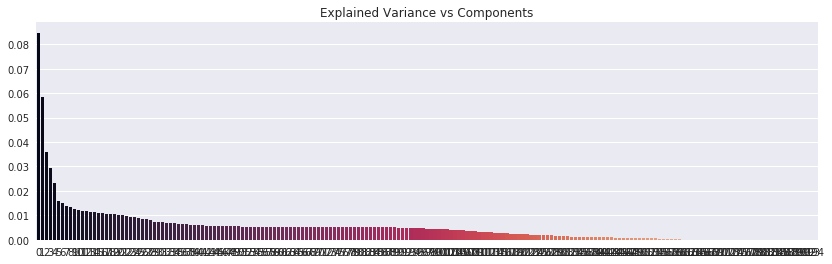

In [52]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

y=pca.explained_variance_ratio_
x=np.arange(0, len(y))

f, ax = plt.subplots(figsize=(14, 4))
plt.title('Explained Variance vs Components')
sns.barplot(x=x, y=y, palette="rocket")


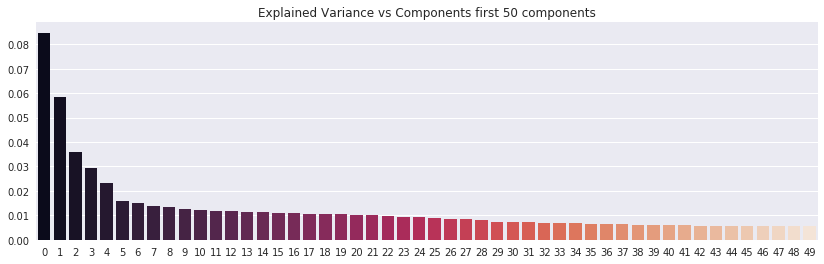

In [53]:
y=pca.explained_variance_ratio_[:50]
x=np.arange(0, 50)

f, ax = plt.subplots(figsize=(14, 4))
plt.title('Explained Variance vs Components first 50 components')
sns.barplot(x=x, y=y, palette="rocket")


In [54]:
list_contribution = pd.DataFrame((100*pca.explained_variance_ratio_))
list_contribution["val"]=list_contribution[0].round(1)
list_contribution.head(50)

,0,val
0,8.471519,8.5
1,5.857232,5.9
2,3.611083,3.6
3,2.934545,2.9
4,2.330061,2.3
5,1.606467,1.6
6,1.505105,1.5
7,1.376307,1.4
8,1.341782,1.3
9,1.266113,1.3


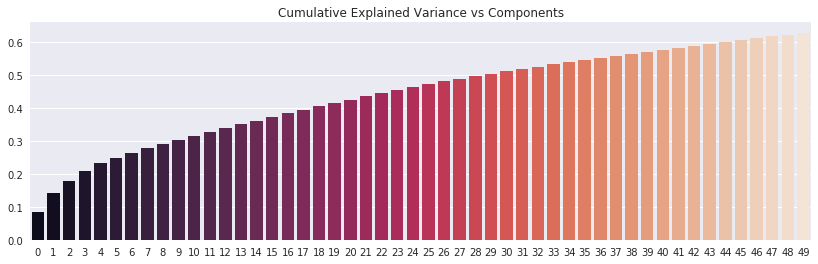

In [55]:
y_cumulative = np.cumsum(y)
f, ax = plt.subplots(figsize=(14, 4))
plt.title('Cumulative Explained Variance vs Components')
sns.barplot(x=x, y=y_cumulative, palette="rocket")

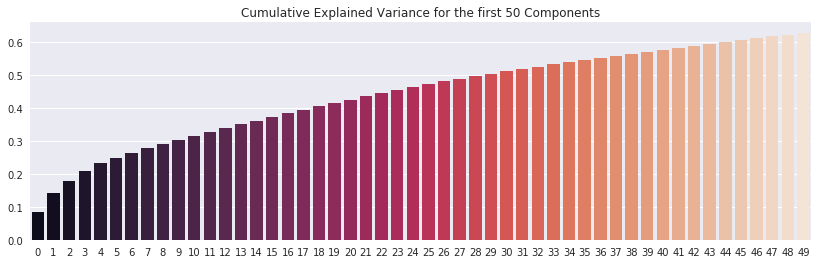

In [57]:
y=pca.explained_variance_ratio_[:50]
x=np.arange(0, 50)
y_cumulative = np.cumsum(y)

f, ax = plt.subplots(figsize=(14, 4))
plt.title('Cumulative Explained Variance for the first 50 Components')
sns.barplot(x=x, y=y_cumulative, palette="rocket")

### Identify the Number of Components Needed 

In the analysis it was decided to keep the first 28 components.
Based on the contribution that each component has on explaining the variability of the model.
The threshold was put to 0.8%.

In [58]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_28 = PCA(n_components=28) 
pca_28.fit(df_ss)


PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [59]:
# Trasformed dataset trough PCA 
df_ss_transformed = pca_28.fit_transform(df_ss)

### Discussion 2.2: Perform Dimensionality Reduction
The current aim was to extract the components that could have a relevant meaning on the explained model variability.
Looking on the slope of the explained variability of each component, it was decide to filter out any component with less that 0.8% variability explanation.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [60]:
def PCA_anlylysis(df, component, pca):
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
    components = components.iloc[(component - 1)].sort_values(ascending=False) #ordered by abs value....

    components=components.reindex(index=components.abs().sort_values(ascending=False).index)
    
    components = components.head(20)
    print("Top 20 Map Weights for the component and Corresponding Feature Names")
    print(components)
    
    fig, ax = plt.subplots(figsize = (12,4))
    components.plot(ax = ax, kind = 'bar');
    plt.title('Top 20 Map Weights for the component and Corresponding Feature Names')
    ax.set_ylabel("Feature Weights component {}".format( component))
    return components


### Map Weights for the First Principal Component

Top 20 Map Weights for the component and Corresponding Feature Names
MOBI_REGIO            -0.1992
LP_STATUS_GROB_1.0     0.1876
KBA05_ANTG1           -0.1873
FINANZ_MINIMALIST     -0.1834
PLZ8_ANTG1            -0.1792
PLZ8_ANTG3             0.1771
KBA05_GBZ             -0.1765
welness                0.1765
HH_EINKOMMEN_SCORE     0.1751
PLZ8_ANTG4             0.1721
PLZ8_BAUMAX            0.1690
ORTSGR_KLS9            0.1507
EWDICHTE               0.1477
FINANZ_HAUSBAUER       0.1361
PLZ8_GBZ              -0.1337
KONSUMNAEHE           -0.1297
LP_STATUS_FEIN_1.0     0.1254
INNENSTADT            -0.1237
KBA05_ANTG4            0.1237
LP_LEBENSPHASE_GROB   -0.1204
Name: 0, dtype: float64


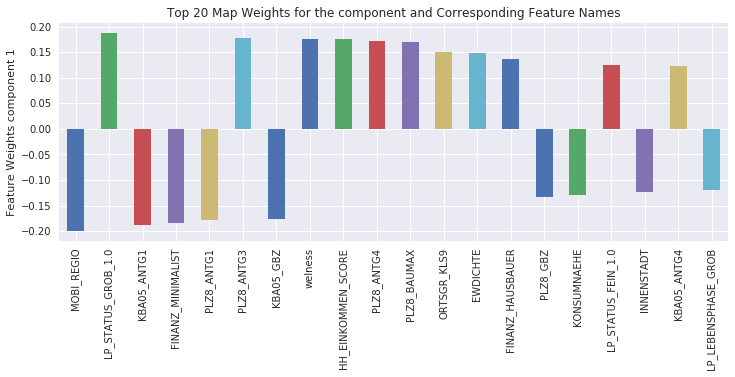

In [61]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.df
_ = PCA_anlylysis(df_ss, 1, pca_28)

First Component:
represent people that tend to move frequently
(OBI_REGIO: tendency to move)

They are good average  earners
LP_STATUS_GROB_1.0  
welness

and they tend to to live in flat 
where the number of family for micro cell is quite low.
PLZ8_ANTG1            
PLZ8_ANTG3

they seems "single in careers"

### Map Weights for the Second Principal Component

Top 20 Map Weights for the component and Corresponding Feature Names
generation              -0.2348
ALTERSKATEGORIE_GROB     0.2333
FINANZ_SPARER           -0.2222
SEMIO_REL               -0.2202
SEMIO_PFLICHT           -0.2129
FINANZ_VORSORGER         0.2119
FINANZ_UNAUFFAELLIGER   -0.2101
SEMIO_TRADV             -0.2082
ZABEOTYP_3               0.1998
FINANZ_ANLEGER          -0.1992
SEMIO_ERL                0.1846
SEMIO_RAT               -0.1684
SEMIO_KULT              -0.1666
SEMIO_LUST               0.1615
ONLINE_AFFINITAET       -0.1590
RETOURTYP_BK_S           0.1574
SEMIO_FAM               -0.1312
FINANZTYP_1             -0.1299
W_KEIT_KIND_HH           0.1281
SEMIO_MAT               -0.1246
Name: 1, dtype: float64


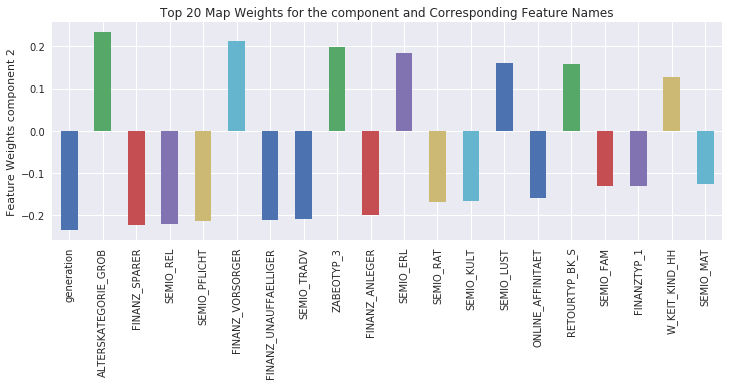

In [62]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
_ = PCA_anlylysis(df_ss, 2, pca_28)


The second component:

The second component is related with the age of the person middle age.

generation              
ALTERSKATEGORIE_GROB

They tend to be money-saver 
FINANZ_SPARER

Normally with average relation with religion 
SEMIO_REL 

They seems to be related with family men in the middle age.

### Map Weights for the Third Principal Component

Top 20 Map Weights for the component and Corresponding Feature Names
ANREDE_KZ           -0.3348
SEMIO_VERT           0.3155
SEMIO_KAEM          -0.3043
SEMIO_DOM           -0.2704
SEMIO_KRIT          -0.2572
SEMIO_FAM            0.2528
SEMIO_SOZ            0.2518
SEMIO_KULT           0.2392
SEMIO_ERL           -0.1969
FINANZ_ANLEGER      -0.1573
SEMIO_RAT           -0.1526
FINANZTYP_5          0.1407
FINANZ_MINIMALIST    0.1330
ZABEOTYP_1           0.1242
SHOPPER_TYP_0.0      0.1234
SEMIO_REL            0.1153
SHOPPER_TYP_2.0     -0.1062
GREEN_AVANTGARDE     0.0983
avan_main           -0.0983
FINANZTYP_1         -0.0980
Name: 2, dtype: float64


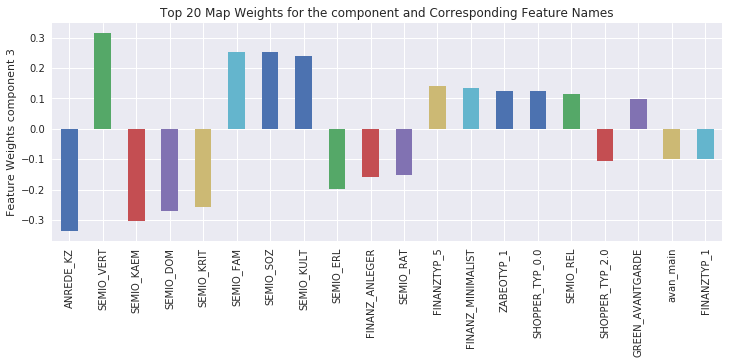

In [63]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
_ = PCA_anlylysis(df_ss, 3, pca_28)


the third components:

normally male persons
ANREDE_KZ

with strong personality

SEMIO_VERT  Not dream-full
SEMIO_KAEM combative attitude
SEMIO_DOM  dominant-minded
SEMIO_KRIT  critical-minded
SEMIO_FAM   not family-minded

### Discussion 2.3: Interpret Principal Components

The first component seems related 
they seems "single in careers" or person focused on the carrier.

The second component seems related with family men in the middle age.

The third component seems related with the typology of the person male with strong personality

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [73]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans


number of cluster: 1, score value 59119165.23011349
number of cluster: 2, score value 51245059.7866801
number of cluster: 3, score value 47592545.00898182
number of cluster: 4, score value 45242806.90106195
number of cluster: 5, score value 43393933.63327523
number of cluster: 6, score value 42170193.57701179
number of cluster: 7, score value 41215503.88929394
number of cluster: 8, score value 40093607.36954043
number of cluster: 9, score value 39262958.45756846
number of cluster: 10, score value 38699872.07137078
number of cluster: 11, score value 37936101.185721405
number of cluster: 12, score value 37148212.80619531
number of cluster: 13, score value 36954205.69056857
number of cluster: 14, score value 35992132.90798823
number of cluster: 15, score value 35972792.28814844
number of cluster: 16, score value 35296072.168782525
number of cluster: 17, score value 34494476.67115072
number of cluster: 18, score value 34355692.971507914
number of cluster: 19, score value 34040465.95723187


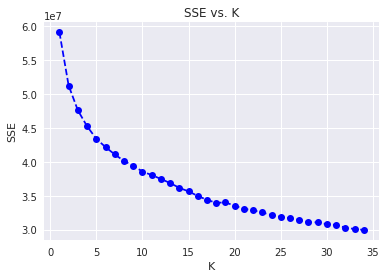

In [74]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
data = df_ss_transformed
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,35))

for center in centers:
    print("number of cluster: {}, score value {}".format(center, get_kmeans_score(data, center)))
    scores.append(get_kmeans_score(data, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

### 5 Clusters Have been Selected 

In [101]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=5).fit(df_ss_transformed)  


In [102]:
predictions = kmeans.predict(df_ss_transformed)


In [103]:
clustered = pd.concat([pd.DataFrame(df_ss_transformed),pd.DataFrame(predictions,columns=["group"])],axis=1)

In [104]:
clustered.head(3)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,group
0,4.570032,-3.942076,-3.236944,1.429281,0.797339,1.800818,-1.155544,0.228401,1.111977,2.934808,...,6.554599,12.265787,-2.794725,-1.773753,0.211082,-0.720556,0.785311,1.852312,-0.995751,2
1,-0.461998,-0.638402,-3.270712,0.790535,-4.134972,1.202377,-1.279877,0.721721,0.030146,-1.304318,...,-0.944430,0.807058,-0.880068,2.191921,-0.800233,-0.070077,0.521562,-1.338254,-0.320837,0
2,-0.424490,0.131252,3.115040,1.438289,3.069649,1.209379,-3.809513,0.948839,-2.803310,-3.518086,...,-0.881057,0.527440,1.340739,1.567600,1.042044,-1.477538,0.981438,0.479300,-0.785158,3


In [105]:
clustered["group"].describe()

count    623209.000000
mean          2.169819
std           1.362328
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: group, dtype: float64

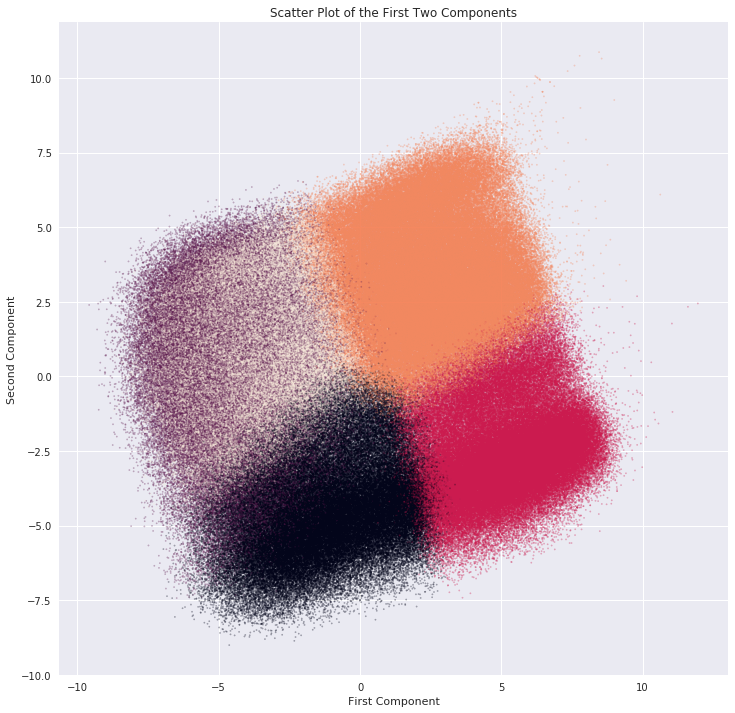

In [106]:
plt.subplots(figsize=(12, 12))
plt.title('Scatter Plot of the First Two Components')
plt.xlabel("First Component")
plt.ylabel("Second Component");


plt.scatter(clustered[0], clustered[1], label=clustered['group'],
               alpha=0.3, c=clustered['group'], s=2)


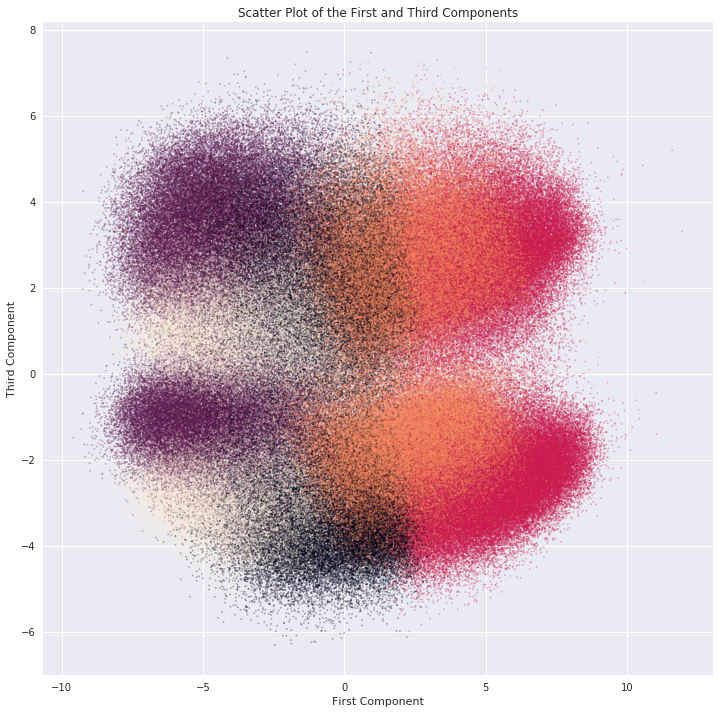

In [107]:
plt.subplots(figsize=(12, 12))
plt.title('Scatter Plot of the First and Third Components')
plt.xlabel("First Component")
plt.ylabel("Third Component");

plt.scatter(clustered[0], clustered[2], label=clustered['group'],
               alpha=0.3, c=clustered['group'], s=2)

### Discussion 3.1: Apply Clustering to General Population

The change of the slop of the within-cluster distance across the number of clusters is between 4 and 7.
The number of 5 clusters have been select as the point, where the line seems to decrease linearly.

For my curiosity i have plotted the two scatter plots of the first vs second and first vs third components, to see how the group are distributed and are overlapping. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [108]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [130]:
customers.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,generation,avan_main,est,west,welness,rural,GEBAEUDETYP_5.0
count,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,...,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.0
mean,3.529154,1.323452,4.285171,1.395709,4.596353,1.551516,1.795448,2.769904,0.531628,1.954074,...,0.006970,0.013715,0.007947,2.843354,0.468372,0.808203,0.985334,2.605865,0.231255,0.0
std,0.677143,0.467796,1.003081,0.797901,0.819966,0.959433,0.928984,1.291275,0.499001,0.765816,...,0.083194,0.116304,0.088791,1.317281,0.499001,0.393716,0.120212,1.408235,0.421637,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
25%,3.000000,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,2.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.0
50%,4.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.0
75%,4.000000,2.000000,5.000000,2.000000,5.000000,2.000000,2.000000,4.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,1.000000,4.000000,0.000000,0.0
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,5.000000,1.000000,0.0


### Cleaning the customer data

In [110]:
customers = clean_data(customers)


In [111]:
customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,generation,avan_main,est,west,welness,LifeStage,rural
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,2,0.0,1,1,1,3.0,1
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,2,0.0,1,1,3,4.0,0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,4,1.0,1,1,4,1.0,0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,2,0.0,1,1,3,4.0,0
6,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,2,0.0,1,1,2,3.0,1


### Checking for np.NaN value

In [112]:
customers.isnull().values.any()

False

### Checking if All the Variables are Present in the Model for the Customer Dataset

In [113]:
customers_col=customers.columns
# (list_features) List of features that are used for the analysis.

# one variable is missing after the trasformation
for var in features:
    if not (var in customers_col):
        print("Features not present in the current model:")
        print(var)

Features not present in the current model:
GEBAEUDETYP_5.0


### Adding to the Model the Missing Variable 

In [114]:
customers['GEBAEUDETYP_5.0'] = 0

In [115]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_transormed = scaler.transform(customers)
customers_transormed = pd.DataFrame(customers_transormed, columns=features)

In [116]:
customers_transormed.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,generation,avan_main,est,west,welness,LifeStage,rural
count,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,...,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,1.156430e+05
mean,0.717609,-0.375611,0.901971,-0.872076,0.824355,-0.841184,-0.559385,-0.292712,0.700864,-0.334033,...,-0.108339,-0.154639,37.620829,-2.646433,0.101067,0.451131,7.995008,0.047966,-1.763842,-5.306704e-01
std,0.659672,0.935827,0.737141,0.543063,0.590382,0.662228,0.676951,0.945655,1.177542,1.009455,...,0.650164,0.469045,17.464280,0.343775,0.929091,0.304874,6.821600,0.917094,0.281222,8.362236e-13
min,-1.746291,-1.022678,-1.512224,-1.141401,-1.765051,-1.221857,-1.139028,-1.588887,-0.553670,-1.591638,...,-0.185007,-0.196619,13.181963,-2.969107,-1.806129,-2.047813,0.216076,-1.595957,-1.918084,-5.306704e-01
25%,0.202107,-1.022678,0.692406,-1.141401,0.394976,-1.221857,-1.139028,-0.856545,-0.553670,-1.591638,...,-0.185007,-0.196619,26.439788,-2.969107,0.553670,0.488326,0.216076,-0.224038,-1.918084,-5.306704e-01
50%,1.176307,-1.022678,1.427283,-1.141401,1.114984,-1.221857,-0.410328,-0.856545,1.806129,-0.273496,...,-0.185007,-0.196619,39.697613,-2.969107,0.553670,0.488326,5.060153,0.461922,-1.918084,-5.306704e-01
75%,1.176307,0.977825,1.427283,-0.460787,1.114984,-0.531628,-0.410328,0.608140,1.806129,1.044647,...,-0.185007,-0.196619,52.955438,-2.280180,0.553670,0.488326,14.748308,0.461922,-1.918084,-5.306704e-01
max,1.176307,0.977825,1.427283,1.581058,1.114984,1.539058,1.775773,1.340482,1.806129,1.044647,...,5.405201,5.085970,79.471087,-2.280180,0.553670,0.488326,19.592385,1.147882,-1.251108,-5.306704e-01


### PCA Transformation

In [117]:
customers_pca = pca_28.transform(customers_transormed) 

In [118]:
predictions_customers =kmeans.predict(customers_pca)

In [119]:
clustered_customers = pd.concat([pd.DataFrame(customers_pca),pd.DataFrame(predictions_customers,columns=["group"])],axis=1)

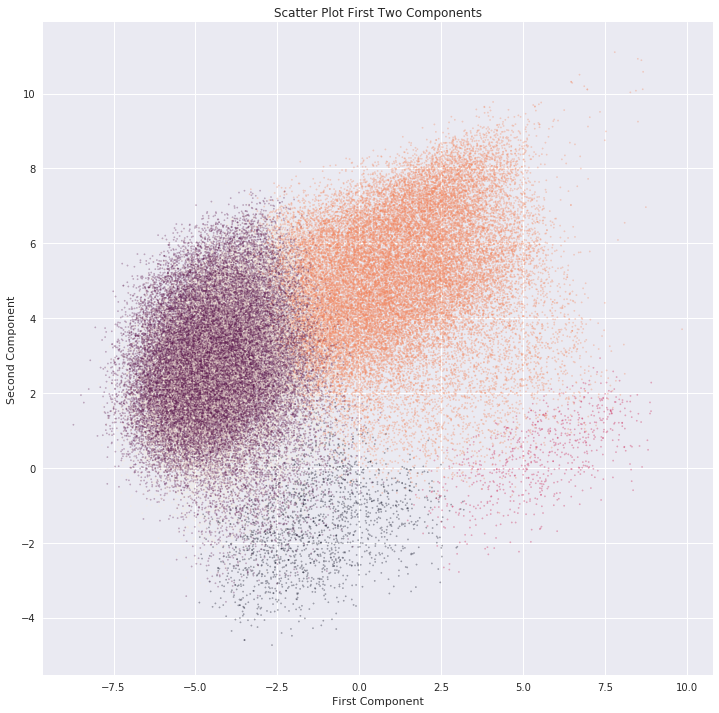

In [120]:
plt.subplots(figsize=(12, 12))
plt.title('Scatter Plot First Two Components')
plt.xlabel("First Component")
plt.ylabel("Second Component");


plt.scatter(clustered_customers [0], clustered_customers [1], label=clustered_customers ['group'],
               alpha=0.3, c=clustered_customers ['group'], s=2)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

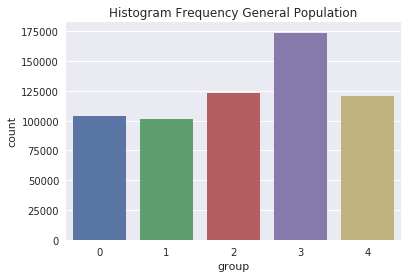

In [121]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
import seaborn as sns
sns.set(style="darkgrid")
plt.title('Histogram Frequency General Population')
ax = sns.countplot(x="group", data=clustered)


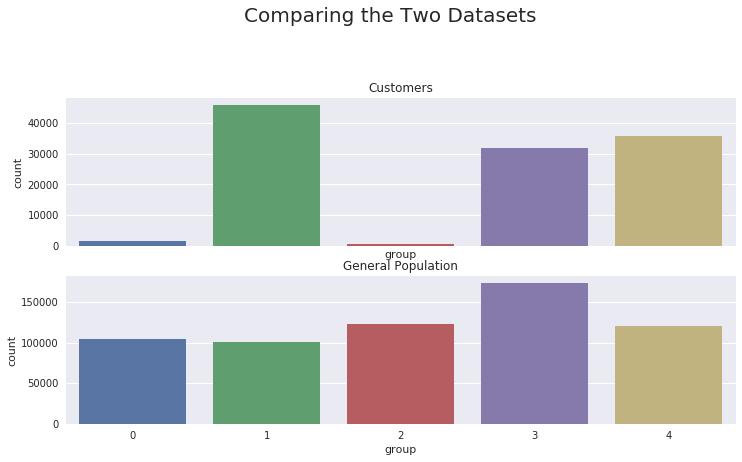

In [122]:
f, (ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(12,6))
plt.figsize=(12, 12)
plt.suptitle("Comparing the Two Datasets", y = 1.09, fontsize=20)
ax1.set_title("Customers")
sns.countplot(x="group", data=clustered_customers, ax=ax1 )

ax2.set_title("General Population")
sns.countplot(x="group", data=clustered, ax=ax2 )

The Group Number 1 is underrepresented on the general population, 

The Group Number 2 is underrepresented on the customer population. 

In [123]:
# Function for extracting the PCA components from the kmean group.

def PCA_relevant_weights(group = 1):
    #print(kmeans.cluster_centers_[group])
    centres = pd.DataFrame(kmeans.cluster_centers_[group],columns=["Value"])
    components=centres.reindex(index=centres.abs().sort_values("Value", ascending=False).index)
    return components.head(10)

In [124]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#   group 1.
PCA_relevant_weights(group = 1)


,Value
0,-4.630125
3,2.830356
4,-1.246732
2,1.244553
5,-0.815564
8,0.465835
13,-0.438559
1,0.397684
18,0.375539
10,-0.371432


Top 20 Map Weights for the component and Corresponding Feature Names
MOBI_REGIO            -0.1992
LP_STATUS_GROB_1.0     0.1876
KBA05_ANTG1           -0.1873
FINANZ_MINIMALIST     -0.1834
PLZ8_ANTG1            -0.1792
PLZ8_ANTG3             0.1771
KBA05_GBZ             -0.1765
welness                0.1765
HH_EINKOMMEN_SCORE     0.1751
PLZ8_ANTG4             0.1721
PLZ8_BAUMAX            0.1690
ORTSGR_KLS9            0.1507
EWDICHTE               0.1477
FINANZ_HAUSBAUER       0.1361
PLZ8_GBZ              -0.1337
KONSUMNAEHE           -0.1297
LP_STATUS_FEIN_1.0     0.1254
INNENSTADT            -0.1237
KBA05_ANTG4            0.1237
LP_LEBENSPHASE_GROB   -0.1204
Name: 0, dtype: float64


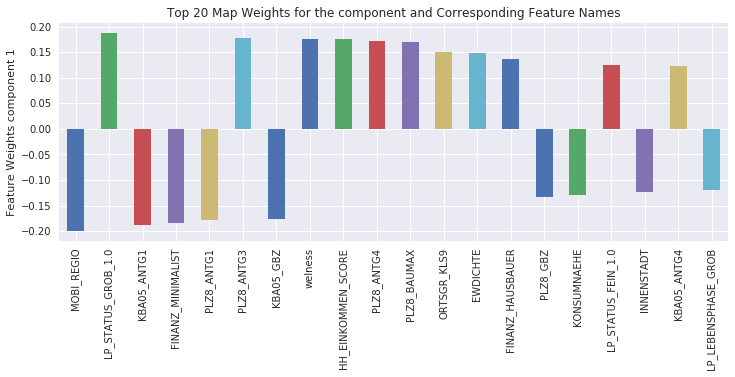

In [127]:
# Weights for the component 0

_ = PCA_anlylysis(df_ss, 0+1, pca_28)

We met earlier this group
represent people that tend to move frequently
(OBI_REGIO: tendency to move)
They are good average  earners
LP_STATUS_GROB_1.0  
welness
and they tend to to live in flat 
where the number of family for micro cell is quite low.
PLZ8_ANTG1            
PLZ8_ANTG3

they seems "single in careers"
the fact that is negative correlate, should mean that is far away from the "single in careers" style.

Top 20 Map Weights for the component and Corresponding Feature Names
avan_main             -0.2403
GREEN_AVANTGARDE       0.2403
LP_STATUS_FEIN_10.0    0.2010
LP_STATUS_GROB_5.0     0.2010
LP_LEBENSPHASE_GROB    0.1951
LP_FAMILIE_FEIN_1.0   -0.1944
LP_FAMILIE_GROB_1.0   -0.1944
EWDICHTE               0.1941
ORTSGR_KLS9            0.1941
ANZ_PERSONEN           0.1785
rural                 -0.1751
LP_FAMILIE_GROB_5.0    0.1636
LP_STATUS_GROB_4.0    -0.1632
BALLRAUM              -0.1554
INNENSTADT            -0.1552
LP_STATUS_FEIN_9.0    -0.1521
HH_EINKOMMEN_SCORE    -0.1479
SEMIO_DOM              0.1453
W_KEIT_KIND_HH        -0.1429
SEMIO_KAEM             0.1422
Name: 3, dtype: float64


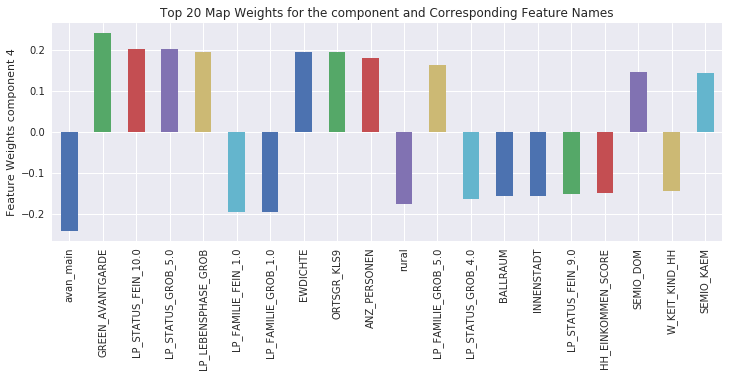

In [128]:
# Weights for the component 3

_ = PCA_anlylysis(df_ss, 3+1, pca_28)

The component identify people with an avantgarde green social political view.

#### The Cluster 1

The cluster is composed of people with an avantgarde green social political view, and not characterized by being single in career.

In [125]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#  group 3.
PCA_relevant_weights(group = 2)

,Value
0,5.136827
1,-2.411061
8,0.470525
3,0.319683
5,-0.311497
25,-0.237376
9,0.230956
10,0.219108
22,-0.209534
15,0.178162


The first component is present as the previous group but this time is strong correlated.

Top 20 Map Weights for the component and Corresponding Feature Names
generation              -0.2348
ALTERSKATEGORIE_GROB     0.2333
FINANZ_SPARER           -0.2222
SEMIO_REL               -0.2202
SEMIO_PFLICHT           -0.2129
FINANZ_VORSORGER         0.2119
FINANZ_UNAUFFAELLIGER   -0.2101
SEMIO_TRADV             -0.2082
ZABEOTYP_3               0.1998
FINANZ_ANLEGER          -0.1992
SEMIO_ERL                0.1846
SEMIO_RAT               -0.1684
SEMIO_KULT              -0.1666
SEMIO_LUST               0.1615
ONLINE_AFFINITAET       -0.1590
RETOURTYP_BK_S           0.1574
SEMIO_FAM               -0.1312
FINANZTYP_1             -0.1299
W_KEIT_KIND_HH           0.1281
SEMIO_MAT               -0.1246
Name: 1, dtype: float64


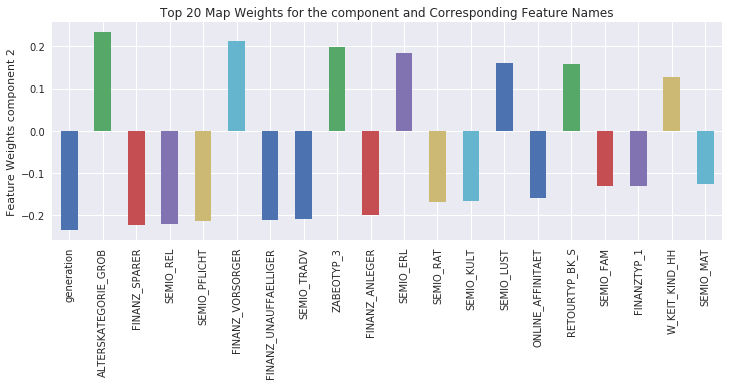

In [129]:
# Weights for the component 1

_ = PCA_anlylysis(df_ss, 1+1, pca_28)

We met earlier the second component

The second component is related with the age of the person middle age.

generation
ALTERSKATEGORIE_GROB

They tend to be money-saver FINANZ_SPARER

Normally with average relation with religion SEMIO_REL

They seems to be related with family men in the middle age.

But in case is negative correlated.

#### cluster 2

This group identify the single in carrier.

### Discussion 3.3: Compare Customer Data to Demographics Data

The conclusion on the analysis of the two cluster Groups,
the company market is strong on person with a avangard green political view, but not in the group called "in Carrier focused"

It could means that if the company want to expand his market on this segment as well, it should increase its offer to the single in carrier.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.